In [1]:
from datetime import date
from io import BytesIO
from IPython import display

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

import base64
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import uuid

In [2]:
import model_card_toolkit as mctlib

In [3]:
cancer = load_breast_cancer()

X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [4]:
# Utility function that will export a plot to a base-64 encoded string that the model card will accept.

def plot_to_str():
    img = BytesIO()
    plt.savefig(img, format='png')
    return base64.encodebytes(img.getvalue()).decode('utf-8')

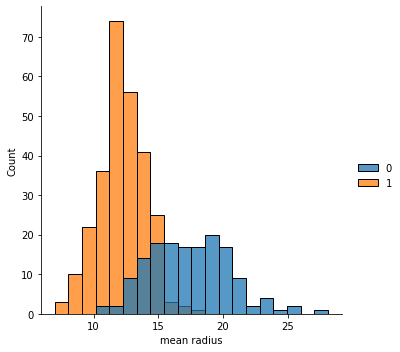

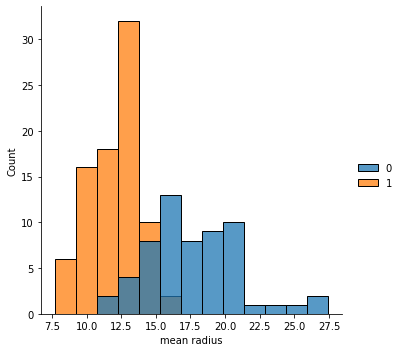

In [5]:
# Plot the mean radius feature for both the train and test sets

sns.displot(x=X_train['mean radius'], hue=y_train)
mean_radius_train = plot_to_str()

sns.displot(x=X_test['mean radius'], hue=y_test)
mean_radius_test = plot_to_str()

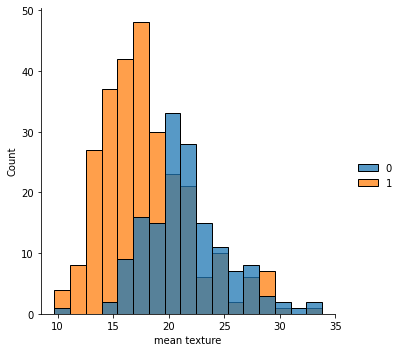

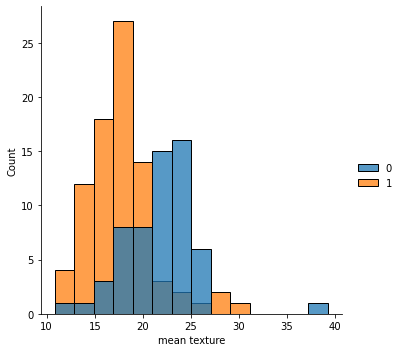

In [6]:
# Plot the mean texture feature for both the train and test sets

sns.displot(x=X_train['mean texture'], hue=y_train)
mean_texture_train = plot_to_str()

sns.displot(x=X_test['mean texture'], hue=y_test)
mean_texture_test = plot_to_str()

In [7]:
# Create a classifier and fit the training data

clf = GradientBoostingClassifier().fit(X_train, y_train)

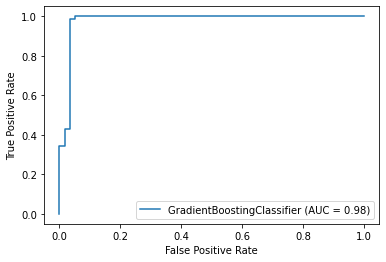

In [8]:
# Plot a ROC curve

plot_roc_curve(clf, X_test, y_test)
roc_curve = plot_to_str()

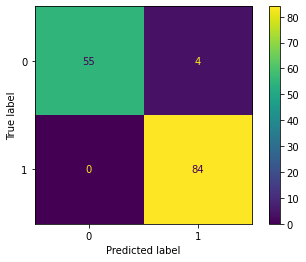

In [9]:
# Plot a confusion matrix

plot_confusion_matrix(clf, X_test, y_test)
confusion_matrix = plot_to_str()

In [10]:
mc = mctlib.ModelCard()
mct = mctlib.ModelCardToolkit(output_dir = "output/")
model_card = mct.scaffold_assets()

In [11]:
model_card.model_details.name = 'Breast Cancer Wisconsin (Diagnostic) Dataset'
model_card.model_details.overview = (
    'This model predicts whether breast cancer is benign or malignant based on '
    'image measurements.')
model_card.model_details.owners = [
    mctlib.Owner(name= 'Model Cards Team', contact='model-cards@google.com', role="auditor")
]
model_card.model_details.references = [
    mctlib.Reference(reference='https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)'),
    mctlib.Reference(reference='https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf')
]
model_card.model_details.version.name = str(uuid.uuid4())
model_card.model_details.version.date = str(date.today())

model_card.considerations.ethical_considerations = [mctlib.Risk(
    name=('Manual selection of image sections to digitize could create '
            'selection bias'),
    mitigation_strategy='Automate the selection process'
)]
model_card.considerations.limitations = [mctlib.Limitation(description='Breast cancer diagnosis')]
model_card.considerations.use_cases = [mctlib.UseCase(description='Breast cancer diagnosis')]
model_card.considerations.users = [mctlib.User(description='Medical professionals'), mctlib.User(description='ML researchers')]

model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[0].graphics.description = (
  f'{len(X_train)} rows with {len(X_train.columns)} features')
model_card.model_parameters.data[0].graphics.collection = [
    mctlib.Graphic(image=mean_radius_train),
    mctlib.Graphic(image=mean_texture_train)
]
model_card.model_parameters.data.append(mctlib.Dataset())
model_card.model_parameters.data[1].graphics.description = (
  f'{len(X_test)} rows with {len(X_test.columns)} features')
model_card.model_parameters.data[1].graphics.collection = [
    mctlib.Graphic(image=mean_radius_test),
    mctlib.Graphic(image=mean_texture_test)
]

model_card.quantitative_analysis.performance_metrics.append(mctlib.PerformanceMetric())
model_card.quantitative_analysis.performance_metrics[0].type = "accuracy"
model_card.quantitative_analysis.performance_metrics[0].value = str((49 + 89) / (49 + 89 + 2 + 3))
model_card.quantitative_analysis.performance_metrics[0].slice = "training"
model_card.quantitative_analysis.performance_metrics[0].graphics.description = (
  'ROC curve and confusion matrix')
model_card.quantitative_analysis.performance_metrics[0].graphics.collection = [
    mctlib.Graphic(image=roc_curve),
    mctlib.Graphic(image=confusion_matrix)
]

model_card.explainability_analysis.explainability_reports = [
    mctlib.ExplainabilityReport(type="feature importance", slice="training", description="top 5 features")
]

model_card.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(type="fairness parity metric", slice="training", segment="gender", description="TPR")
]

mct.update_model_card(model_card)

In [12]:
md = mct.export_format(template_path="output/template/md/default_template.md.jinja", output_file="model_card.md")

In [13]:
html = mct.export_format()

display.display(display.HTML(html))

Name,Value
"accuracy, training",0.965034965034965


## Prep test dataset

In [14]:
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

from ModelTests.FEAT.SubgroupDifference import SubgroupDifference
from ModelTests.FEAT.SubgroupMetricThreshold import SubgroupMetricThreshold
from ModelTests.FEAT.Permutation import Permutation
from ModelTests.FEAT.SHAPFeatureImportance import SHAPFeatureImportance
from ModelTests.FEAT.FeatureImportance import FeatureImportance
from ModelTests.FEAT.DataShift import DataShift

In [15]:
# Credit dataset
df = pd.read_csv("credit_reject.csv")
x = df.drop("reject", axis=1)
y = df["reject"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.8, random_state=32
)
estimator = RandomForestClassifier(n_estimators=10, max_features="sqrt")
# estimator = LogisticRegression()

# Apply one hot encoding to categorical columns (auto-detect object columns)
ens = ce.OneHotEncoder(use_cat_names=True)
x_train = ens.fit_transform(x_train)
x_test = ens.transform(x_test)

estimator.fit(x_train, y_train)

output = x_test.copy()
y_pred = estimator.predict(x_test)
y_probas = estimator.predict_proba(x_test)[::, 1]
# print(confusion_matrix(y_test, y_pred))

output = ens.inverse_transform(output)
output["truth"] = y_test
output["prediction"] = y_pred
output["prediction_probas"] = y_probas


df_importance = pd.DataFrame(
    {"features": x_test.columns, "value": estimator.feature_importances_}
)
#df_importance = df_importance.sort_values(df_importance.columns[1], ascending=False)
train = ens.inverse_transform(x_train)
test = ens.inverse_transform(x_test)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


## Run some FEAT Tests on it

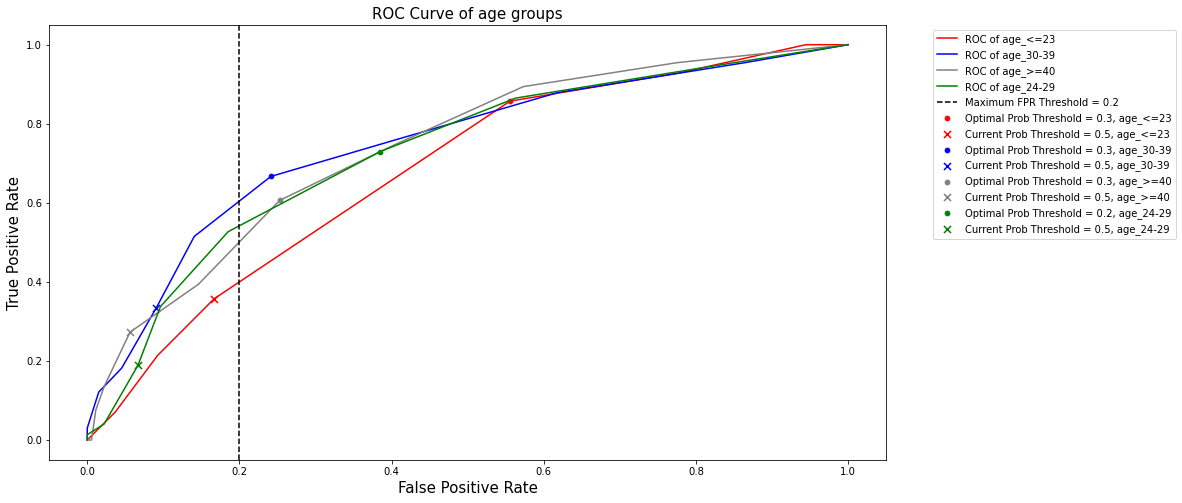

In [16]:
smt_test = SubgroupMetricThreshold(
    #test_name="subgroup metric threshold",
    #test_desc="",
    attr="age",
    metric="fpr",
    threshold=0.20,
    # proba_thresholds = {'<=17':0.5,'>=40':0.6,'18-25':0.4,'26-39':0.3}
)
smt_test.run(df_test_with_output=output)
smt_test.plot()

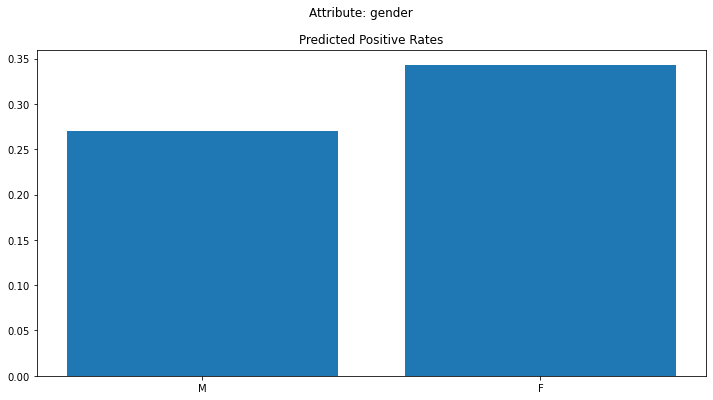

In [17]:
# SubgroupDifference Test
sgd_test = SubgroupDifference(
    #test_name='subgroup diff',
    #test_desc='my first subgroup difference test',
    attr='gender',
    metric='pr',
    method='ratio',
    threshold=1.25,
)
sgd_test.run(output)
sgd_test.plot()

In [18]:
# Permutation Test
pmt = Permutation(
    #test_name='permutation',
    #test_desc='',
    attr='age',
    metric='pr',
    method='ratio',
    threshold=1.5,
)

pmt.run(
    x_test=x_test,
    y_test=y_test,
    encoder=ens,
    model=estimator
)

True

Setting feature_perturbation = "tree_path_dependent" because no background data was given.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


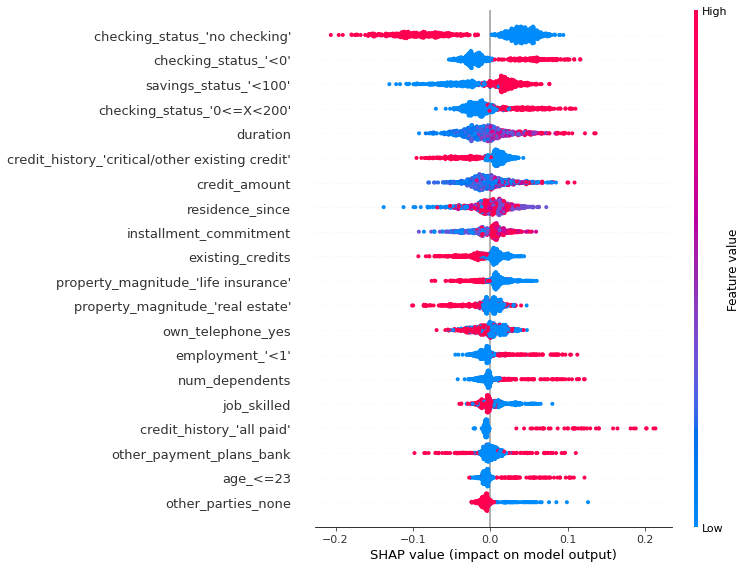

In [19]:
shap_test = SHAPFeatureImportance(
    #test_name='SHAP',
    #test_desc='',
    attrs=['gender','age'],
    threshold=10
)

shap_test.run(
    model=estimator,
    model_type='trees',
    x_train=x_train,
    x_test=x_test,
)
shap_test.shap_summary_plot(x_test)
shap_test.shap_dependence_plot(x_test)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


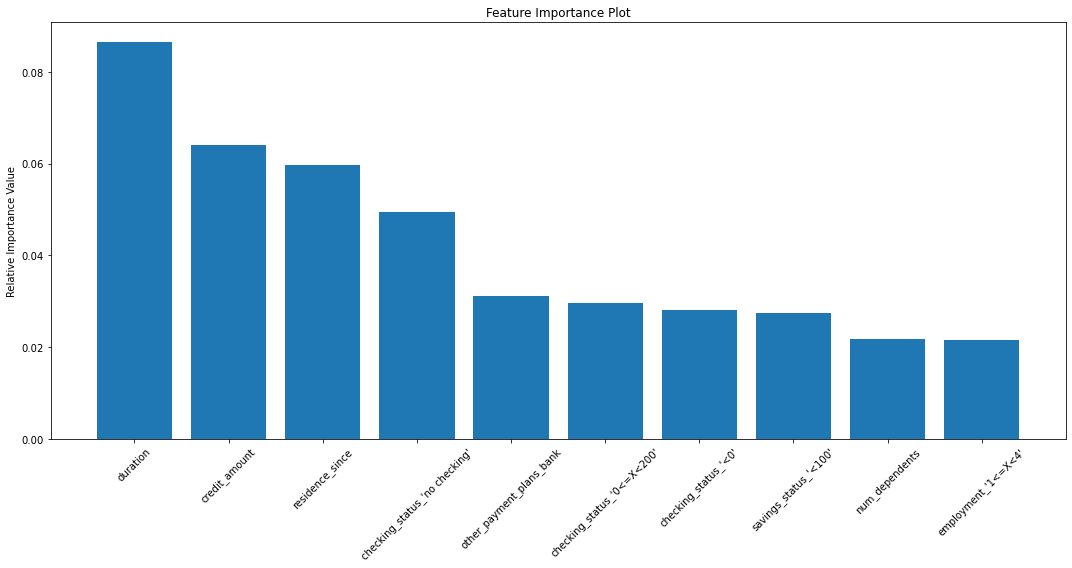

In [20]:
imp_test = FeatureImportance(
    #test_name='my feature importance FEAT test',
    #test_desc='',
    attrs=['gender','age'],
    threshold=10
)

imp_test.run(df_importance)
imp_test.plot(df_importance,threshold=10)

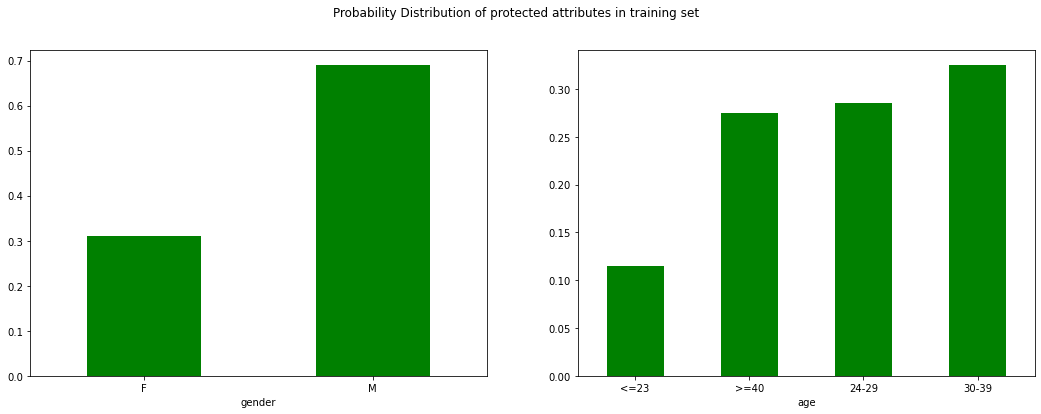

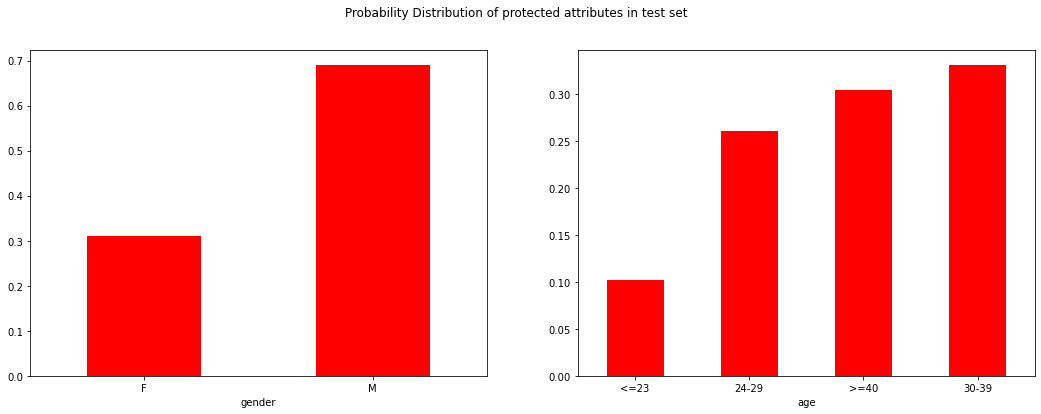

In [21]:
shift_test = DataShift(
    #test_name='my data shift FEAT test',
    #test_desc='',
    protected_attr = ['gender','age'],
    threshold = 0.05
)

shift_test.run(df_train = train, df_eval = test)
shift_test.plot(train, test)


In [22]:
shift_test.result

[]

## Nice representation of test objects

In [23]:
smt_test

SubgroupMetricThreshold(test_name='ROC/Threshold Test', test_desc='Test if the groups within age attribute passes the fpr threshold. To pass, fpr/fnr has to be lower than the threshold or tpr/tnr has to be greater than the thresholds specified. Also, mark the optimal points that maximises the AUC value for each group', result=           fpr at current probability threshold  passed
age_<=23                                  0.167    True
age_30-39                                 0.090    True
age_>=40                                  0.056    True
age_24-29                                 0.067    True, passed=True, attr='age', metric='fpr', threshold=0.2, proba_thresholds=None)

In [24]:
sgd_test

SubgroupDifference(test_name='Subgroup Disparity Test', test_desc='Test if the maximum ratio of the positive rate of any 2 groups within gender attribute exceeds the threshold. To pass, this value cannot exceed the threshold.', result=   gender_pr_max_ratio
0                 1.27, passed=False, attr='gender', metric='pr', method='ratio', threshold=1.25)

In [25]:
pmt

Permutation(test_name='Subgroup Permutation Test', test_desc='Test if the ratio of the positive rate of the groups within age attribute of the original dataset and the perturn dataset exceeds the threshold. To pass, this value cannot exceed the threshold', result=           pr of original data  pr of perturbed data  ratio  passed
age_24-29                0.354                 0.287  1.233    True
age_30-39                0.249                 0.309  1.242    True
age_<=23                 0.341                 0.268  1.273    True
age_>=40                 0.270                 0.287  1.061    True, passed=True, attr='age', metric='pr', method='ratio', threshold=1.5)

In [26]:
shap_test

SHAPFeatureImportance(test_name='Shapely Feature Importance Test', test_desc='Test if the subgroups of the protected attributes are the top ranking influential variables under shapely feature importance value. To pass, subgroups should not be ranked in the top 10 features', result=           feature_rank  passed
age_<=23           19.0    True
age_30-39          21.0    True
age_>=40           22.0    True
age_24-29          23.0    True
gender_M           32.0    True
gender_F           45.0    True, passed=True, attrs=['gender', 'age'], threshold=10)

In [27]:
imp_test

FeatureImportance(test_name='Feature Importance Test', test_desc='Test if the subgroups of the protected attributes are the top ranking important variables. To pass, subgroups should not be ranked in the top 10 features', result=           feature_rank  passed
age_30-39          20.0    True
age_24-29          25.0    True
age_<=23           27.0    True
gender_M           28.0    True
age_>=40           29.0    True
gender_F           37.0    True, passed=True, attrs=['gender', 'age'], threshold=10)

## Convert test objects to a model-card-compatible format

In [28]:
# init model card test objects
mc_smt_test = mctlib.Test()
mc_sgd_test = mctlib.Test()
mc_pmt_test = mctlib.Test()
mc_shap_test = mctlib.Test()
mc_imp_test = mctlib.Test()

# assign tests to them
mc_smt_test.read_model_test(smt_test)
mc_sgd_test.read_model_test(sgd_test)
mc_pmt_test.read_model_test(pmt)
mc_imp_test.read_model_test(imp_test)
mc_shap_test.read_model_test(shap_test)

## Add test to model card and update it

In [29]:
model_card.fairness_analysis.fairness_reports = [
    mctlib.FairnessReport(type='Model metric across subgroups should be within a defined threshold', tests=[mc_smt_test]),
    mctlib.FairnessReport(type='Model metric across subgroups should be similar', tests=[mc_sgd_test]),
    mctlib.FairnessReport(type='Model metric for subgroups in original data and perturbed data should be similar', tests=[mc_pmt_test]),
    mctlib.FairnessReport(type="Protected Attributes should not be model's top important features", tests=[mc_imp_test,mc_shap_test])
]

mct.update_model_card(model_card)

## Display HTML

In [30]:
html2 = mct.export_format(template_path="output/template/html/mod_template.html.jinja", output_file="model_card.html")

display.display(display.HTML(html2))